## Grupo de Energía de Bogotá (GEB) stock values dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

In [2]:
df_geb = pd.read_csv('../data/raw/Grupo Energía de Bogotá.csv')
df_geb['Instrument Name'] = 'GEB'
df_geb.head(10)

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.,Instrument Name
0,20.05.2022,"2,350.00","2,342.00","2,389.00","2,332.00","1,34M",1.73%,GEB
1,19.05.2022,"2,310.00","2,395.00","2,395.00","2,301.00","1,01M",-3.75%,GEB
2,18.05.2022,"2,400.00","2,440.00","2,450.00","2,393.00","1,82M",-1.23%,GEB
3,17.05.2022,"2,430.00","2,410.00","2,434.00","2,410.00","1,86M",1.25%,GEB
4,16.05.2022,"2,400.00","2,363.00","2,400.00","2,361.00","2,23M",2.13%,GEB
5,13.05.2022,"2,350.00","2,390.00","2,435.00","2,350.00","703,57K",-0.42%,GEB
6,12.05.2022,"2,360.00","2,340.00","2,400.00","2,340.00","928,74K",1.33%,GEB
7,11.05.2022,"2,329.00","2,393.00","2,395.00","2,322.00","1,42M",-0.04%,GEB
8,10.05.2022,"2,330.00","2,410.00","2,420.00","2,330.00","1,30M",-2.51%,GEB
9,09.05.2022,"2,390.00","2,450.00","2,470.00","2,390.00","1,43M",-2.45%,GEB


Let us look at a first description of the GEB dataset:

In [3]:
df_geb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Fecha            3056 non-null   object
 1   Último           3056 non-null   object
 2   Apertura         3056 non-null   object
 3   Máximo           3056 non-null   object
 4   Mínimo           3056 non-null   object
 5   Vol.             3056 non-null   object
 6   % var.           3056 non-null   object
 7   Instrument Name  3056 non-null   object
dtypes: object(8)
memory usage: 191.1+ KB


This dataset consists of 3056 rows and 7 columns (minus the identifier 'Instrument Name'), with no missing values. Every row represents the value of GEBs stock in a particular day (during the 2009-2022 time period), where the columns provide basic information about the stock's behaviour. We notice that, unfortunately, there are no entries for most holidays and weekend days.

From business knowledge, it is believed that the stock prices variation of the GEB might have an effect on ISA's stock values. However, this claim should not be validated immediately without an analysis of the GEB dataset. Before proceeding with said exploratory data analysis, we will perform data cleaning.

In [4]:
# Correct typing for dates
df_geb['Fecha'] = pd.to_datetime(df_geb['Fecha'], format="%d.%m.%Y")
# Correct typing for numerical values. Commas had to be removed so that .astype() would work
df_geb['Último'] = df_geb['Último'].str.replace(',', '', regex=False).astype(float)
df_geb['Apertura'] = df_geb['Apertura'].str.replace(',', '', regex=False).astype(float)
df_geb['Máximo'] = df_geb['Máximo'].str.replace(',', '', regex=False).astype(float)
df_geb['Mínimo'] = df_geb['Mínimo'].str.replace(',', '', regex=False).astype(float)
# The 'Vol.' column contains abbreviations of numerical values, formatted as strings.
# In the original data, 'M' stands for millions and 'K' for thousands. We convert these to float using string methods.
def abbrev_to_float(string):
    # Convert to millions, ommit the last character. Before multiplication, commas must be removed
    if string[-1] == 'M':
        return float(string[:-1].replace(',', '')) * 1000000
    # Convert to thousands
    if string[-1] == 'K':
        return float(string[:-1].replace(',', '')) * 1000
df_geb['Vol.'] = df_geb['Vol.'].apply(abbrev_to_float)
# The entries in the percentage variation column are strings with an unnecesary '%' symbol
df_geb['% var.'] = df_geb['% var.'].str.replace('%', '', regex=False).astype(float)

In [5]:
df_geb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3056 entries, 0 to 3055
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Fecha            3056 non-null   datetime64[ns]
 1   Último           3056 non-null   float64       
 2   Apertura         3056 non-null   float64       
 3   Máximo           3056 non-null   float64       
 4   Mínimo           3056 non-null   float64       
 5   Vol.             3050 non-null   float64       
 6   % var.           3056 non-null   float64       
 7   Instrument Name  3056 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 191.1+ KB


Let us add and rename some relevant columns. This is necessary in order to analyze our data thoroughly and creating date filters later on:

In [6]:
df_geb['Year'] = df_geb['Fecha'].dt.year
df_geb['Month'] = df_geb['Fecha'].dt.month
df_geb['Day'] = df_geb['Fecha'].dt.day
df_geb['Close Previous'] = df_geb['Último'].shift(-1)
# df_geb['V'] = ((df_geb['Último']-df_geb['Close previous'])/(df_geb['Último']))*100
df_geb = df_geb.rename(columns={'Fecha':'Date', 'Último':'Close', 'Apertura':'Open', 'Máximo':'High', 'Mínimo':'Low',
 'Vol.':'Volume', '% var.': 'Variation'})
df_geb

,Date,Close,Open,High,Low,Volume,Variation,Instrument Name,Year,Month,Day,Close Previous
0,2022-05-20,2350.0,2342.0,2389.0,2332.0,1.340000e+08,1.73,GEB,2022,5,20,2310.0
1,2022-05-19,2310.0,2395.0,2395.0,2301.0,1.010000e+08,-3.75,GEB,2022,5,19,2400.0
2,2022-05-18,2400.0,2440.0,2450.0,2393.0,1.820000e+08,-1.23,GEB,2022,5,18,2430.0
3,2022-05-17,2430.0,2410.0,2434.0,2410.0,1.860000e+08,1.25,GEB,2022,5,17,2400.0
4,2022-05-16,2400.0,2363.0,2400.0,2361.0,2.230000e+08,2.13,GEB,2022,5,16,2350.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3051,2009-10-07,888.8,900.0,900.0,888.8,6.830000e+08,1.02,GEB,2009,10,7,879.8
3052,2009-10-06,879.8,850.0,879.8,850.0,6.120000e+08,4.74,GEB,2009,10,6,840.0
3053,2009-10-05,840.0,840.0,840.0,840.0,2.640000e+08,9.01,GEB,2009,10,5,770.6
3054,2009-10-02,770.6,770.6,770.6,770.6,6.168700e+10,-35.80,GEB,2009,10,2,1200.4


In [7]:
df_geb = df_geb[['Instrument Name', 'Date', 'Year', 'Month', 'Day', 'Open', 'High', 'Low',
 'Close', 'Close Previous', 'Volume', 'Variation']]
df_geb = df_geb.set_index('Date')
df_geb

,Instrument Name,Year,Month,Day,Open,High,Low,Close,Close Previous,Volume,Variation
Date,,,,,,,,,,,
2022-05-20,GEB,2022,5,20,2342.0,2389.0,2332.0,2350.0,2310.0,1.340000e+08,1.73
2022-05-19,GEB,2022,5,19,2395.0,2395.0,2301.0,2310.0,2400.0,1.010000e+08,-3.75
2022-05-18,GEB,2022,5,18,2440.0,2450.0,2393.0,2400.0,2430.0,1.820000e+08,-1.23
2022-05-17,GEB,2022,5,17,2410.0,2434.0,2410.0,2430.0,2400.0,1.860000e+08,1.25
2022-05-16,GEB,2022,5,16,2363.0,2400.0,2361.0,2400.0,2350.0,2.230000e+08,2.13
...,...,...,...,...,...,...,...,...,...,...,...
2009-10-07,GEB,2009,10,7,900.0,900.0,888.8,888.8,879.8,6.830000e+08,1.02
2009-10-06,GEB,2009,10,6,850.0,879.8,850.0,879.8,840.0,6.120000e+08,4.74
2009-10-05,GEB,2009,10,5,840.0,840.0,840.0,840.0,770.6,2.640000e+08,9.01


In [8]:
# Save the clean dataframe into a csv file
df_geb.to_csv('../data/dev/Grupo Energía de Bogotá.csv')

## Exploratory data analysis

Now we are in suitable conditions to obtain basic statistical descriptors:

In [9]:
df_geb.describe()

,Year,Month,Day,Open,High,Low,Close,Close Previous,Volume,Variation
count,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,3056.000000,3055.000000,3.050000e+03,3056.000000
mean,2015.608966,6.462696,15.832788,1802.698901,1815.792543,1790.478802,1804.070877,1803.892177,1.608925e+08,0.059045
std,3.657233,3.486600,8.762283,457.659728,461.092049,452.612996,455.686597,455.654086,1.155869e+09,2.066726
min,2009.000000,1.000000,1.000000,770.600000,770.600000,770.600000,770.600000,770.600000,2.900000e+04,-35.800000
25%,2012.000000,3.000000,8.000000,1458.750000,1473.750000,1450.000000,1463.750000,1462.500000,2.880200e+07,-0.550000
50%,2016.000000,6.000000,16.000000,1770.000000,1785.000000,1753.100000,1775.000000,1775.000000,6.798800e+07,0.000000
75%,2019.000000,10.000000,23.000000,2090.000000,2100.000000,2075.000000,2091.250000,2090.000000,1.540000e+08,0.610000
max,2022.000000,12.000000,31.000000,2927.000000,2945.000000,2917.000000,2929.000000,2929.000000,6.168700e+10,71.490000


It would seem that stock prices have been highly variable, as the variation percentage has gone almost between -36% and 72% along these years. However, with its third quartile equal to 0.61%, this high variation may seldom occur. The values in other columns appear to vary more significantly.  

Let us provide visualizations for this dataset. We begin with the two most relevant variables regarding stock behaviour; closing prices (Último) and variation percentages (% var.).

Text(0.5, 1.0, 'Grupo de Energía de Bogotá (GEB)')

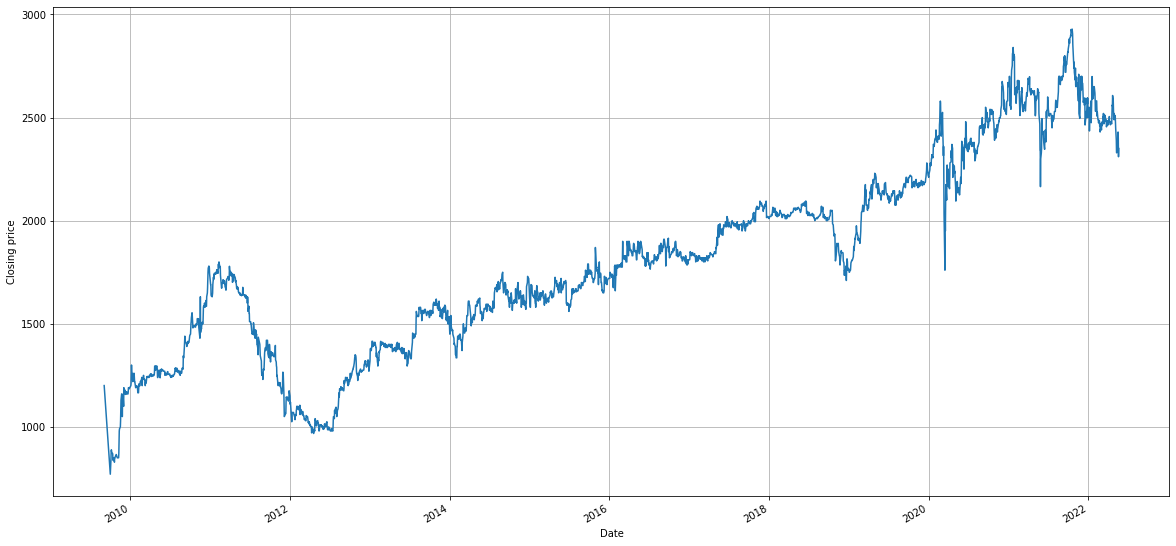

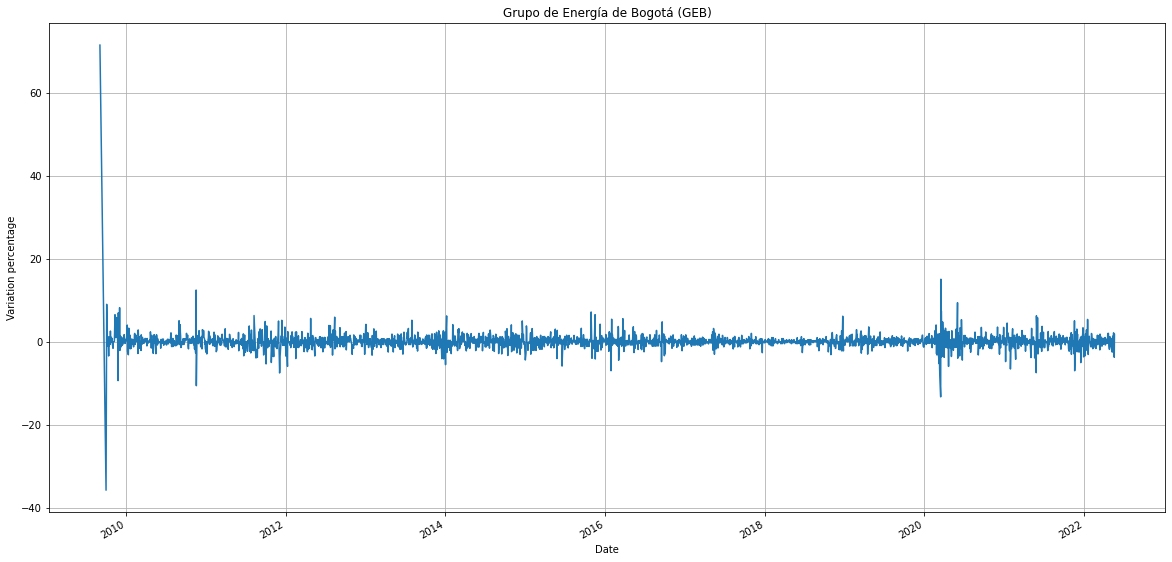

In [10]:
ax1 = df_geb.plot(use_index=True, y='Close', style=['-'], figsize=(20,10), ylabel='Closing price', legend=False, grid=True)
ax2 = df_geb.plot(use_index=True, y='Variation', style=['-'], figsize=(20, 10), ylabel='Variation percentage', legend=False, grid=True)

plt.title('Grupo de Energía de Bogotá (GEB)')

The closing prices exhibit an increasing trend throughout the years, not without significant ups and downs. Notable decreases have occured in 2012 and 2019 (the latter may be due to the COVID-19 pandemic). On the other hand, the variation percentage seems to have remained mostly stable (the large variations we mentioned earlier are outliers, at the start of the graph) but variations appear to be more frequent in the recent 2020-2022 period.

A dotted plot would allow us to visualize better the previous variations in these graphs. 

<Figure size 432x288 with 0 Axes>

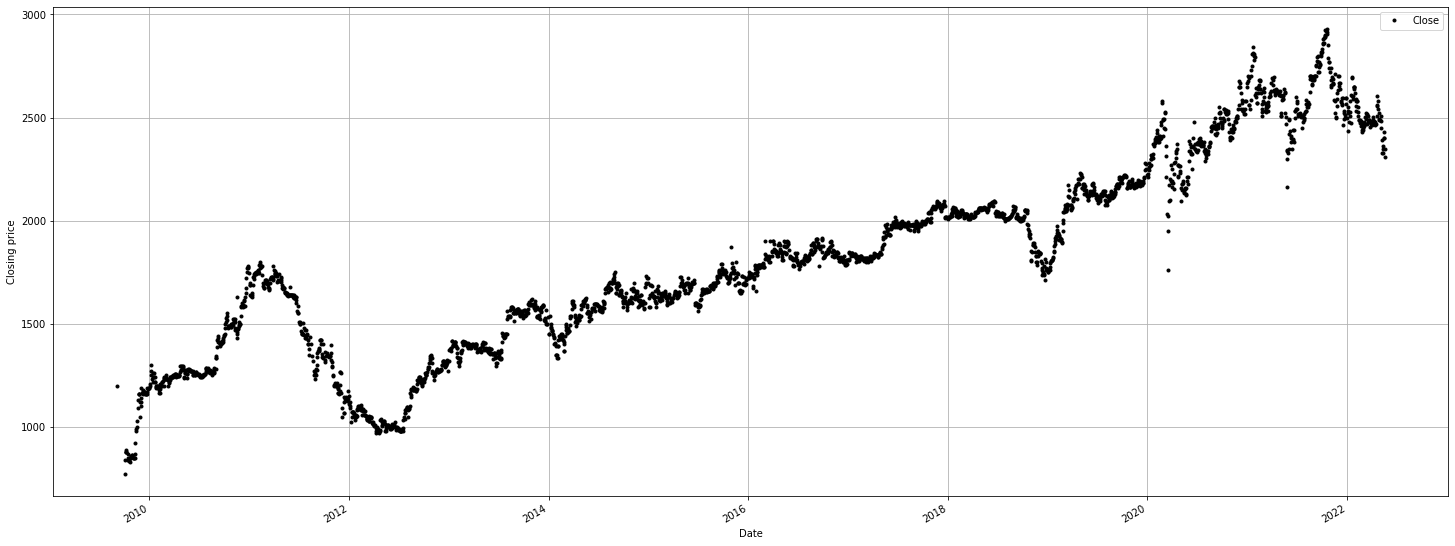

<Figure size 432x288 with 0 Axes>

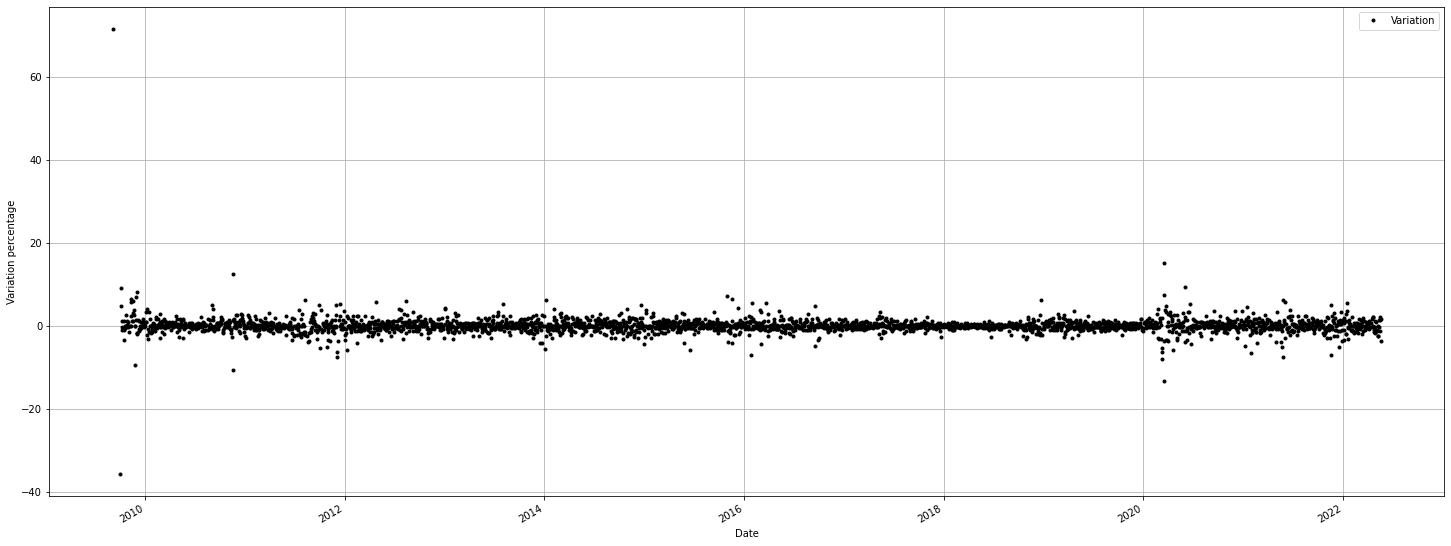

In [11]:
plt.figure()
ax3 = df_geb.plot(use_index=True, y='Close', style='k.', grid=True, figsize=(25,10), ylabel='Closing price')
plt.figure()
ax4 = df_geb.plot(use_index=True, y='Variation', style='k.', grid=True, figsize=(25,10), ylabel='Variation percentage')

Now, let us now examine the distributions of our variables via histograms:

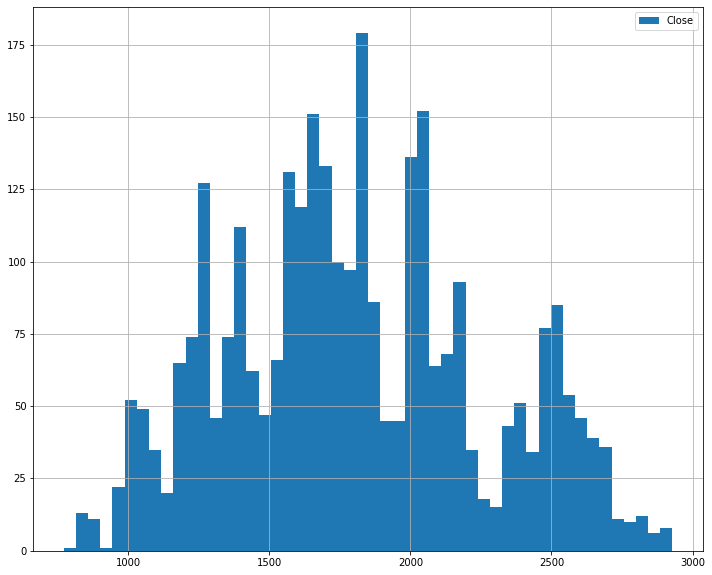

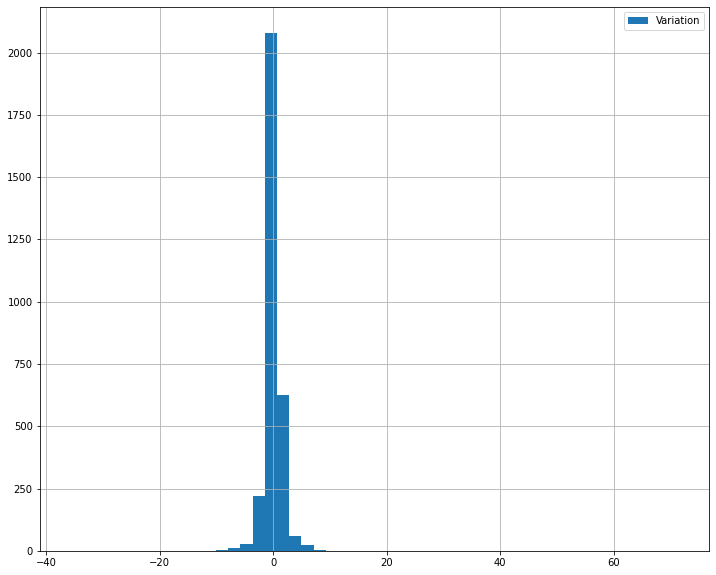

In [12]:
plt.figure()
ax5 = df_geb['Close'].hist(bins=50, figsize=(12,10), legend=True)

plt.figure()
ax6 = df_geb['Variation'].hist(bins=50, figsize=(12,10), legend=True)

The histogram for closing price shows that the stock has been worth worth most often ~1700 COP, although other frequent values occur in the 1500 COP - 2000 COP range. This distribution does not seem particularly skewed, but it is not completely symmetrical.  For the variation percentage,  the values are most often near zero, as mentioned earlier.

Density plots, as an alternative to histograms, yield similar results:

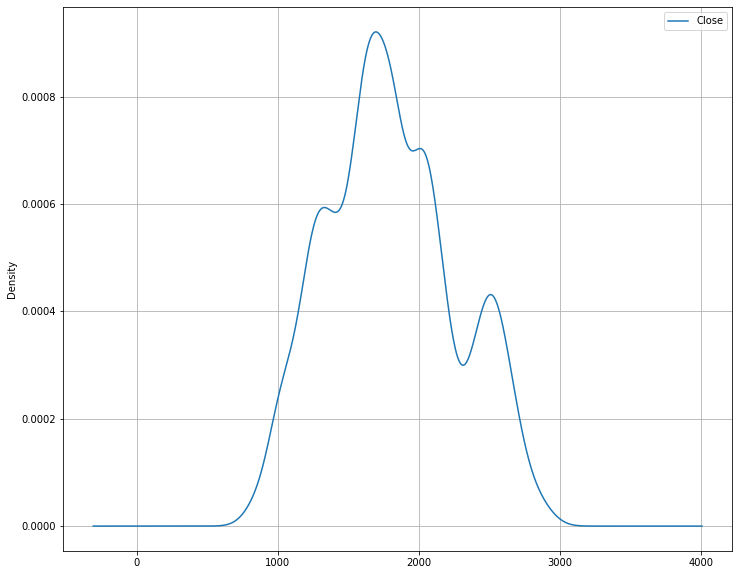

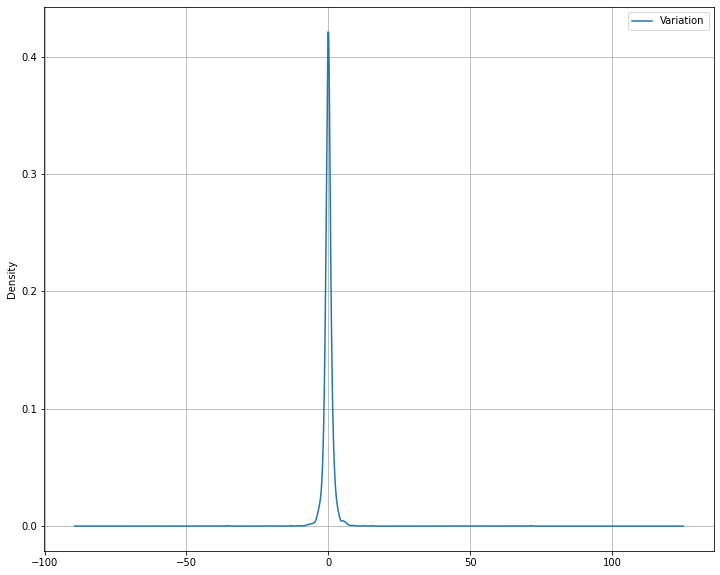

In [13]:
ax6 = df_geb['Close'].plot(kind='kde', figsize=(12,10), grid=True, legend=True)
plt.figure()
ax7 = df_geb['Variation'].plot(kind='kde', figsize=(12,10), grid=True, legend=True)

In order to reduce data variation, we showcase a moving average consisting of a window of 200 periods that presents the average evolution of the price based on the previous 200 data entries. This strategy does indeed reduce variations due to small peaks/valleys:

<AxesSubplot:xlabel='Date', ylabel='Closing price'>

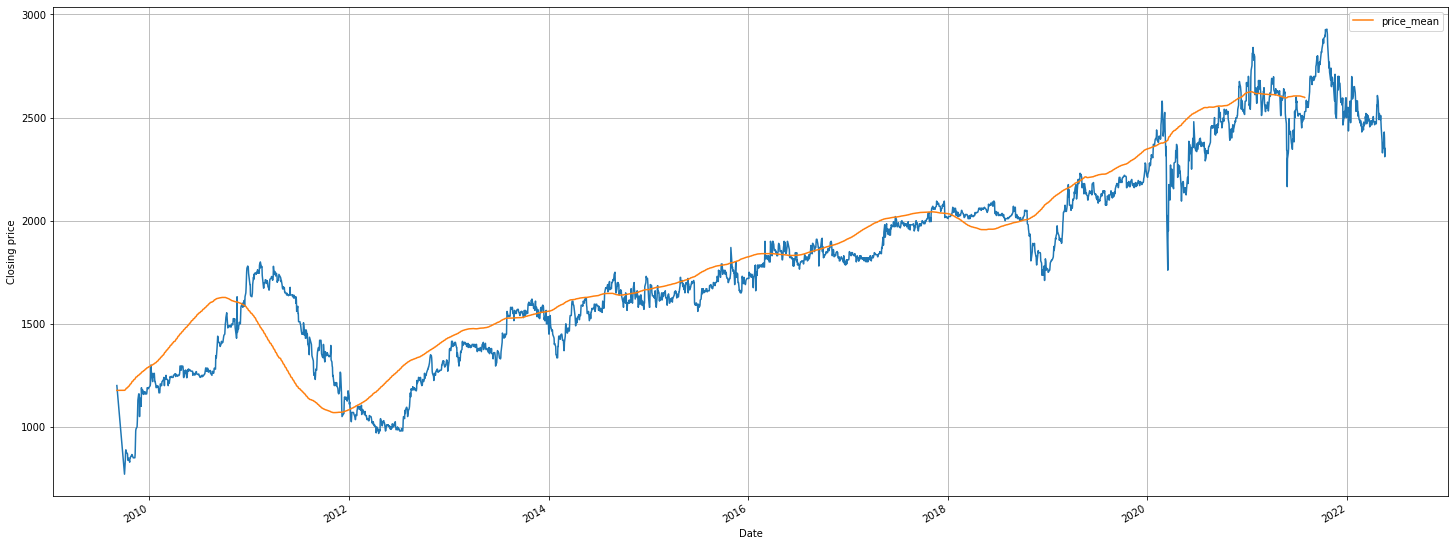

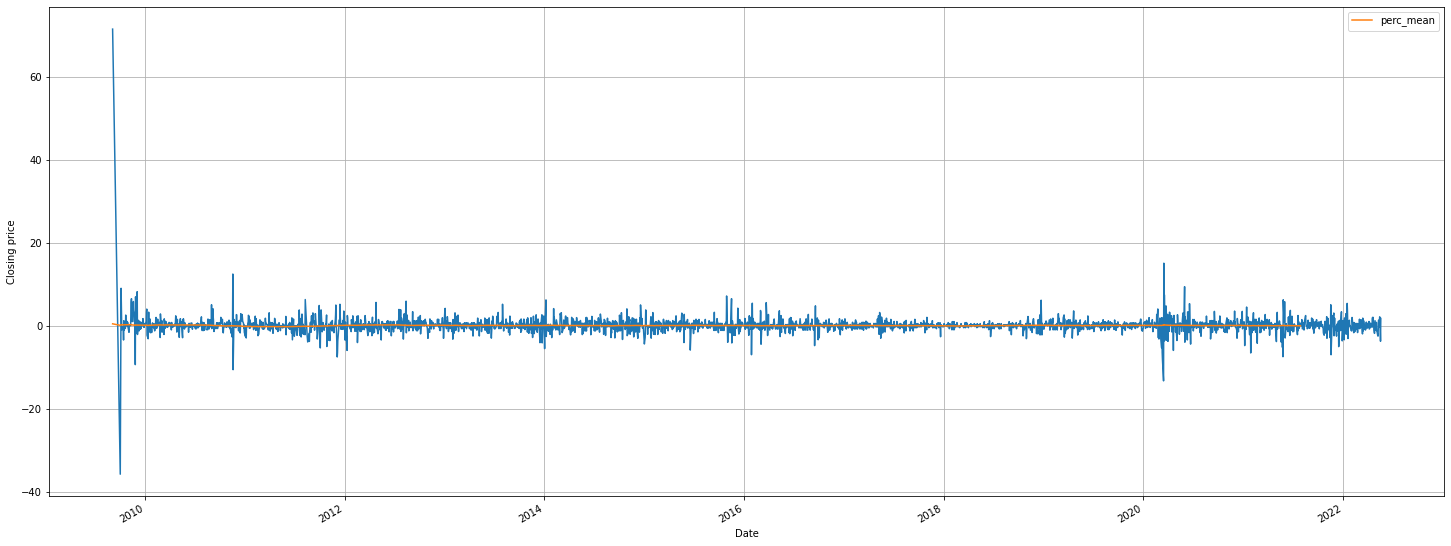

In [14]:
df_geb['price_mean'] = df_geb['Close'].rolling(200, win_type=None).mean()
ax11 = df_geb.plot(use_index=True, y='Close', style=['-'], figsize=(25,10), ylabel='Closing price', legend=False, grid=True)
df_geb.plot(y='price_mean', style=['-', '--', ':'], grid=True, ylabel='Closing price', ax=ax11)

df_geb['perc_mean'] = df_geb['Variation'].rolling(200, win_type=None).mean()
ax22 = df_geb.plot(use_index=True, y='Variation', style=['-'], figsize=(25,10), ylabel='Variation percentage',
 legend=False, grid=True)
df_geb.plot(y='perc_mean', style=['-', '--', ':'], grid=True, ylabel='Closing price', ax=ax22)

Let us now reduce variation by smoothing the data. Exponential smoothing allows noise to be smoothed without time shift implications, and thus is preferred

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Date', ylabel='Closing price'>

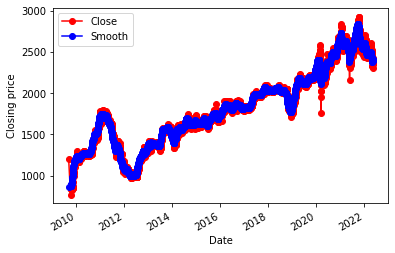

In [15]:
model = SimpleExpSmoothing(df_geb['Close']).fit(smoothing_level=.1, optimized=True)
df_geb['Smooth'] = model.fittedvalues
ax8 = df_geb.plot(y='Close', marker='o', color='red', ylabel='Closing price')
df_geb.plot(y='Smooth', marker='o', color='blue', ylabel='Closing price', ax=ax8)

A lag plot allows us to check for randomness. This plot allows to do a price analysis between the observation of the sample in *t* and *t+1* where it is tried to verify if there is any pattern that shows that the series is not random, in other words to verify the existence of correlation between the samples. A lag plot with little data dispersion indicates that the data is not random, and instead follows a certain trend (in this case, we see a positive correlation between observation, which implies that this dataset follows a trend and can be modeled).

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

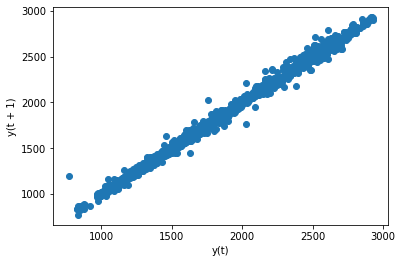

In [16]:
lag_plot(df_geb['Close'])

The absence of mainly random behavior can be verified via an autocorrelation plot. If the plot is distant from zero, then indeed randomness is not a main factor in this time series. Finally for the autocorrelation graph, and as expected for a system with such little variation, it seems to be apparently independent of time, despite logic telling us otherwise, it is an important factor to take into account in case. At the moment we have problems of autocorrelated variables.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

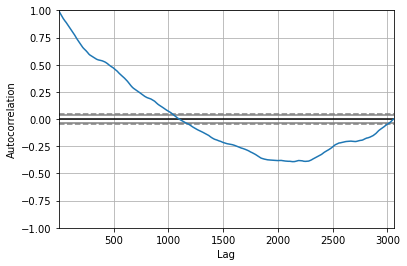

In [17]:
autocorrelation_plot(df_geb['Close'])

Now, let us inspect the distribution of the stock volume via a histogram:

<AxesSubplot:>

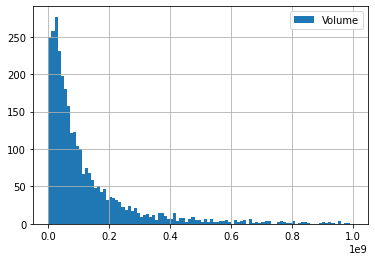

In [18]:
df_geb['Volume'].hist(bins=100, legend=True, range=(0,1e9))

This distribution is right skewed, and thus most volume entries correspond to lower amounts of traded ISA's stocks.

## Yearly price and volume trend

In [19]:
# Reverse chronological order
df_geb = df_geb.loc[::-1] 

<Figure size 432x288 with 0 Axes>

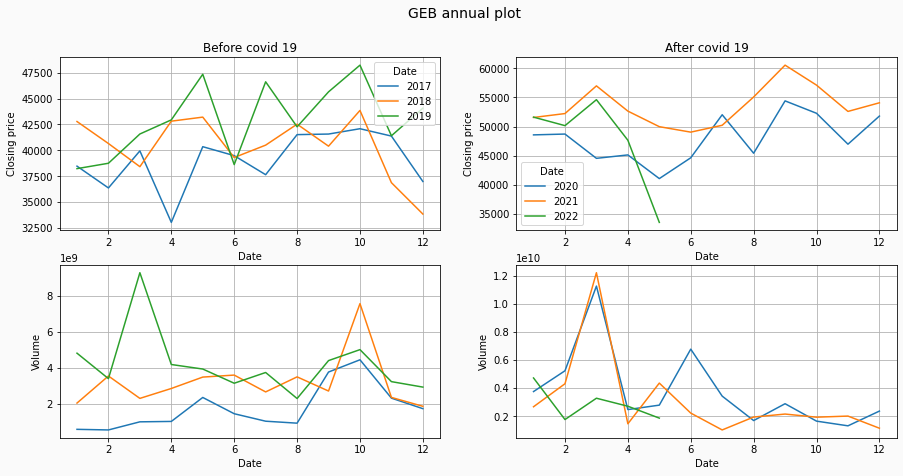

In [20]:
plt.figure()
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), facecolor=(.98, .98, .98))
fig1.suptitle('GEB annual plot', fontsize=14)

df_aux = df_geb.loc['2017-01-01':'2019-12-31']
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Close', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Closing price', grid=True, ax=axes1[0,0])
ax1.set_title('Before covid 19')

df_aux = df_geb.loc['2020-01-01':]
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Close', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Closing price', grid=True, ax=axes1[0,1])
ax1.set_title('After covid 19')

df_aux = df_geb.loc['2017-01-01':'2019-12-31']
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Volume', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Volume', legend=False, grid=True, ax=axes1[1,0])

df_aux = df_geb.loc['2020-01-01':]
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Volume', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Volume', grid=True, legend=False, ax=axes1[1,1])

In [21]:
years = df_geb['Year'].unique()
vol_yearly = pd.DataFrame()
close_yearly = pd.DataFrame()
for y in years:
    df_aux = df_geb[df_geb['Year']==y].groupby('Month')[['Volume','Close']].mean()
    vol_yearly = pd.concat([vol_yearly, df_aux[['Volume']].T.set_index(pd.Index([y]))])
    close_yearly = pd.concat([close_yearly, df_aux[['Close']].T.set_index(pd.Index([y]))])

In [22]:
vol_yearly_mean = pd.DataFrame()
close_yearly_mean = pd.DataFrame()
for y in years:
    vol_yearly_mean[y] = vol_yearly.mean()
    close_yearly_mean[y] = close_yearly.mean()

<Figure size 432x288 with 0 Axes>

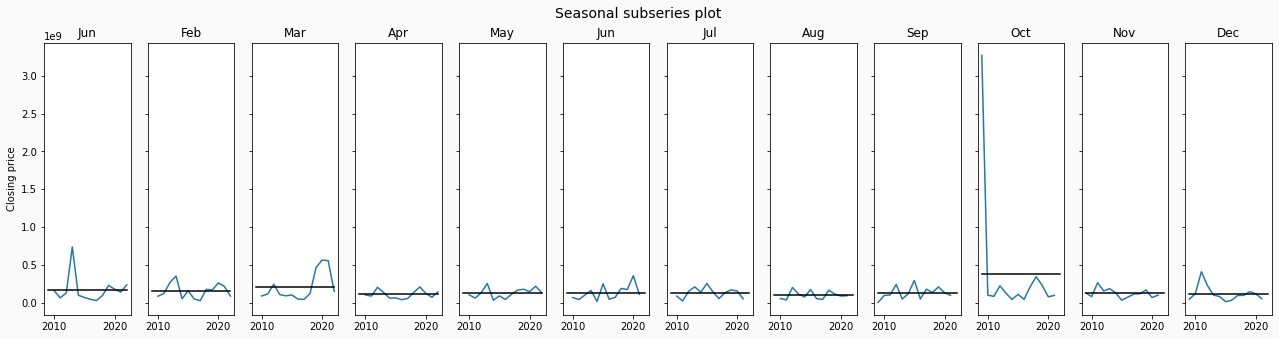

In [23]:
months = ['Jun', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure()
fig1, axes1 = plt.subplots(nrows=1, ncols=12, figsize=(22, 5), sharey=True, facecolor=(.98, .98, .98))
fig1.suptitle('Seasonal subseries plot', fontsize=14)
for i in vol_yearly:
    vol_yearly[i].plot(grid=True, legend=False, title=months[i-1], ylabel='Closing price', ax = axes1[i-1]);
    vol_yearly_mean.T[i].plot(legend=False, ax = axes1[i-1], color ='k');